# ECE 175A
## By: Jay Paek

In [1]:
from scipy.io import loadmat as load
import scipy.io as sio
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
# import cupy as np

In [2]:
data = load('data.mat')
labels = load('label.mat')
train_data = data['imageTrain'].astype('float').reshape((784,5000)).T/255
train_labels = labels['labelTrain'].reshape((5000,))
test_data = data['imageTest'].astype('float').reshape((784,500)).T/255
test_labels = labels['labelTest'].reshape((500,))

## Problem 1
Compute top 10 principle components.

In [3]:
mean = np.mean(train_data, axis=0)
covariance = np.cov(train_data-mean, rowvar=False)

Text(0.5, 1.0, 'Covariance image')

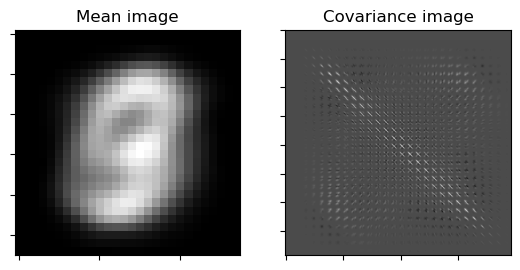

In [4]:
ax, arr = plt.subplots(1,2)
arr[0].imshow(mean.reshape((28,28)), cmap='gray')
arr[0].set_yticklabels([])
arr[0].set_xticklabels([])
arr[0].set_title(f'Mean image')
arr[1].imshow(covariance, cmap='gray')
arr[1].set_yticklabels([])
arr[1].set_xticklabels([])
arr[1].set_title(f'Covariance image')

[783 782 781 780 779 778 777 776 775 774]
Eigenvalues: [5.1953811  3.89857419 3.22630344 2.84595963 2.49438076 2.3266535
 1.7743949  1.5334288  1.45987266 1.22688743]


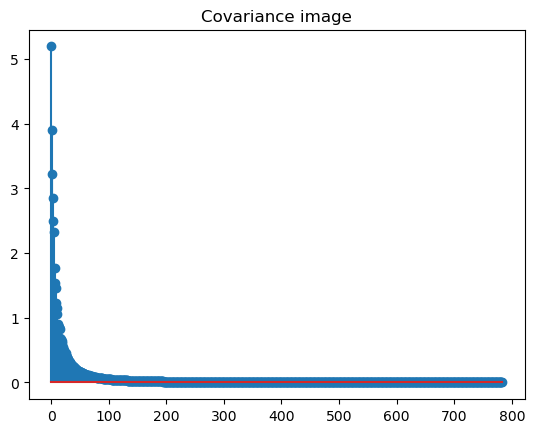

In [5]:
eigenvalues, eigenvectors = np.linalg.eigh(covariance)
top = np.argpartition(eigenvalues, -10)[-10:]
print(np.flip(top))
plt.stem(np.flip(eigenvalues))
plt.title(f'Covariance image')
print(f'Eigenvalues: {np.flip(eigenvalues[top])}')

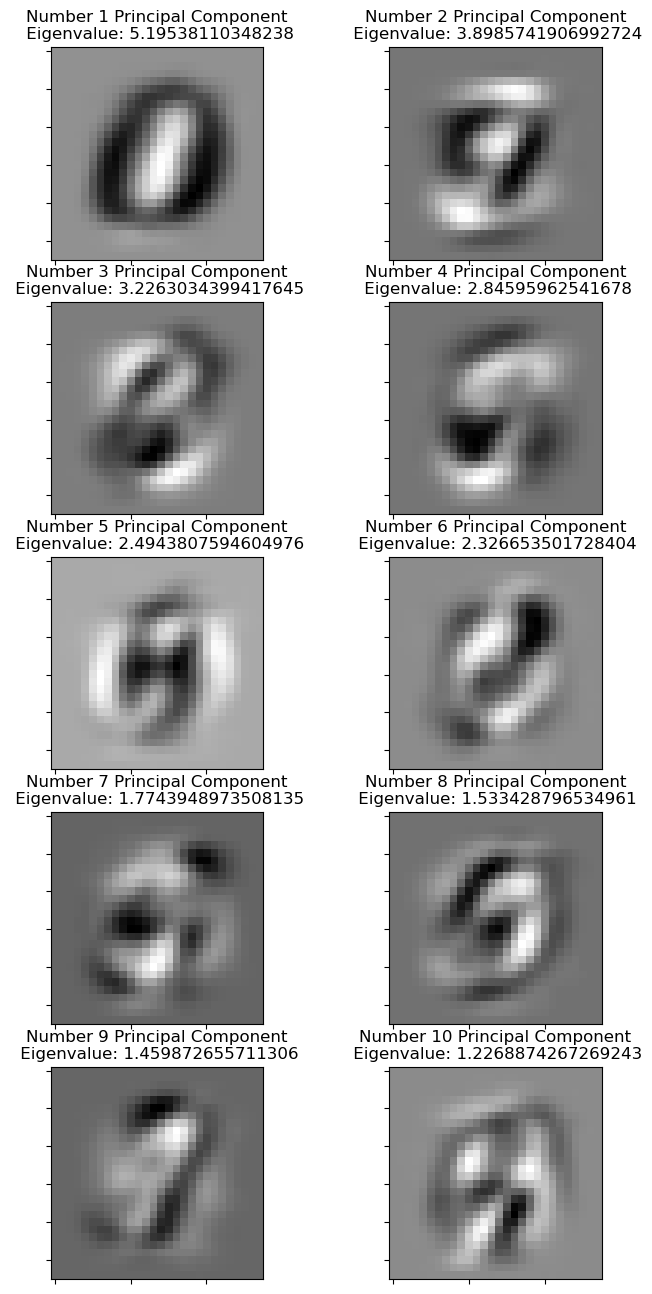

In [6]:
# Display the cluster means as images
ax, arr = plt.subplots(5,2, figsize=(8, 16))
for i in range(10):
    arr[int(i/2)][i%2].imshow(eigenvectors[:, 783-i].reshape((28,28)), cmap='gray')
    arr[int(i/2)][i%2].set_yticklabels([])
    arr[int(i/2)][i%2].set_xticklabels([])
    arr[int(i/2)][i%2].set_title(f'Number {i+1} Principal Component\n Eigenvalue: {eigenvalues[783-i]}')

In [7]:
selected = train_data[train_labels == 5]
covariance_5 = np.cov(selected-np.mean(selected, axis=0), rowvar=False)

Text(0.5, 1.0, 'Covariance image')

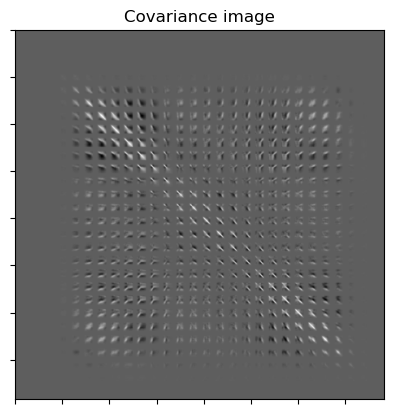

In [8]:
ax, arr = plt.subplots(1,1)
arr.imshow(covariance_5, cmap='gray')
arr.set_yticklabels([])
arr.set_xticklabels([])
arr.set_title(f'Covariance image')

In [9]:
eigenvalues_5, eigenvectors_5 = np.linalg.eigh(covariance_5)
top_5 = np.argpartition(eigenvalues_5, -10)[-10:]
print(np.flip(top_5))

[783 782 781 780 779 778 777 776 775 774]


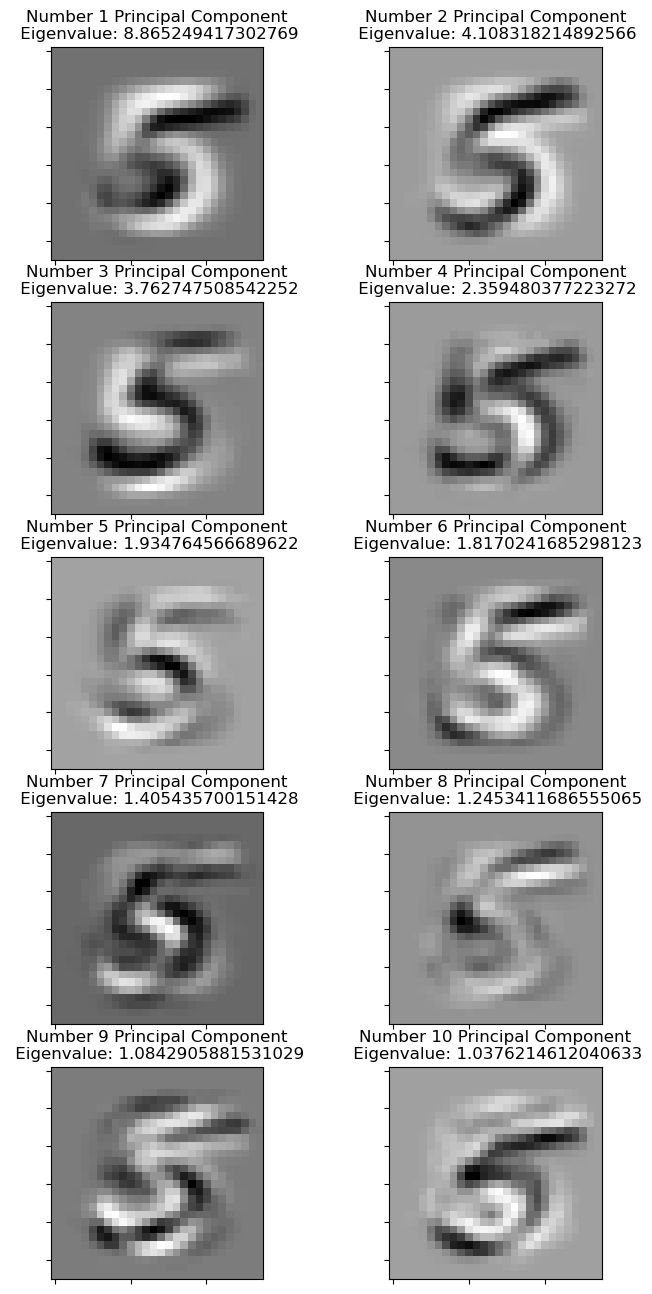

In [10]:
# Display the cluster means as images
ax, arr = plt.subplots(5,2, figsize=(8, 16))
for i in range(10):
    arr[int(i/2)][i%2].imshow(eigenvectors_5[:, 783-i].reshape((28,28)), cmap='gray')
    arr[int(i/2)][i%2].set_yticklabels([])
    arr[int(i/2)][i%2].set_xticklabels([])
    arr[int(i/2)][i%2].set_title(f'Number {i+1} Principal Component\n Eigenvalue: {eigenvalues_5[783-i]}')

## Problem 2
From the eigenvalue plot given, I think that the first 20 principle compnents should be used the eigenvalues begin to shallow out starting from $\lambda_k < 1$

In [11]:
prev_predicted = [36, 65, 36, 36, 43, 33, 33, 37, 30, 40]

Configure expected results

In [12]:
expected = []
for i in range(10):
    expected.append(np.count_nonzero(test_labels == i))
expected

[42, 67, 55, 45, 55, 50, 43, 49, 40, 54]

We can actually simplify the equation for the Bayesian decision rule. Initially:
$$ arg\underset{i}max  \{ -\frac{1}{2} (x- \mu_i)^T \Sigma_{i}^{-1}(x-\mu_i)  - \frac{1}{2}log(2\pi)^d|\Sigma_i| + log(P_Y(i))\}$$
but $log(P_Y(i))$ are the same across each image and each class due to the assumptions. (also multiply by a factor of two.)
$$ arg\underset{i}max  \{ -(x- \mu_i)^T \Sigma_{i}^{-1}(x-\mu_i)  - log(2\pi)^d|\Sigma_i|\}$$


In [13]:
dimensions = [5, 10, 20, 30, 40, 60, 90, 130, 180, 250, 350]
expected = []
# test_data counts
for i in range(10):
    expected.append(np.count_nonzero(test_labels == i))

predicted = np.zeros((11, 10))
for index in range(11):
    d = dimensions[index]
    eigenspace = eigenvectors[:,-1:-1-d:-1]
    # eigenstretch = eigenvalues[-1:-1-d:-1]
    projected_data = train_data@eigenspace
    
    # find projected means, class means, and covariances
    projected_mean = np.mean(projected_data, axis=0)
    # projected_covariance = np.cov(projected_data-projected_mean, rowvar=False)
    projected_means = np.zeros((10,d))
    projected_covariances = np.zeros((10,d,d))
    for i in range(10):
        projected_means[i] = np.mean(projected_data[train_labels == i], axis = 0)
        projected_covariances[i,:,:] =  np.cov(projected_data[train_labels == i] - projected_means[i], rowvar=False)
        
    # Transform Test data
    projected_test = test_data@eigenspace
    # Gaussian Classificiation
    predictions = []
    for image in projected_test:
        predict = np.zeros((10,))
        for i in range(10):
            current_cov = projected_covariances[i,:,:]
            centered = image - projected_means[i,:]
            predict[i] = -(centered)@np.linalg.inv(current_cov)@(centered).T - (np.log(2*np.pi)**d*np.linalg.det(projected_covariances[i,:,:]))
        predictions.append(np.argmax(predict))
        
    for i in range(len(test_labels)):
        if test_labels[i] == predictions[i]:
            predicted[index][test_labels[i]] += 1

In [14]:
predicted

array([[ 0., 67.,  0.,  0., 12.,  0.,  2., 18.,  0.,  0.],
       [ 0., 67.,  0.,  0.,  0.,  0., 34., 35.,  0.,  0.],
       [40., 66.,  0.,  0., 51.,  6., 41., 45.,  0., 53.],
       [41., 60., 54., 42., 53., 49., 37., 47., 37., 45.],
       [41., 60., 54., 44., 53., 47., 36., 46., 36., 44.],
       [41., 58., 53., 43., 53., 48., 39., 45., 38., 44.],
       [42., 54., 53., 43., 52., 48., 37., 45., 37., 40.],
       [42., 54., 53., 41., 53., 44., 39., 44., 37., 38.],
       [42., 51., 53., 42., 52., 40., 38., 43., 35., 39.],
       [41., 51., 52., 41., 51., 33., 37., 44., 33., 36.],
       [12., 49., 27., 15., 22.,  8., 15., 20.,  9.,  8.]])

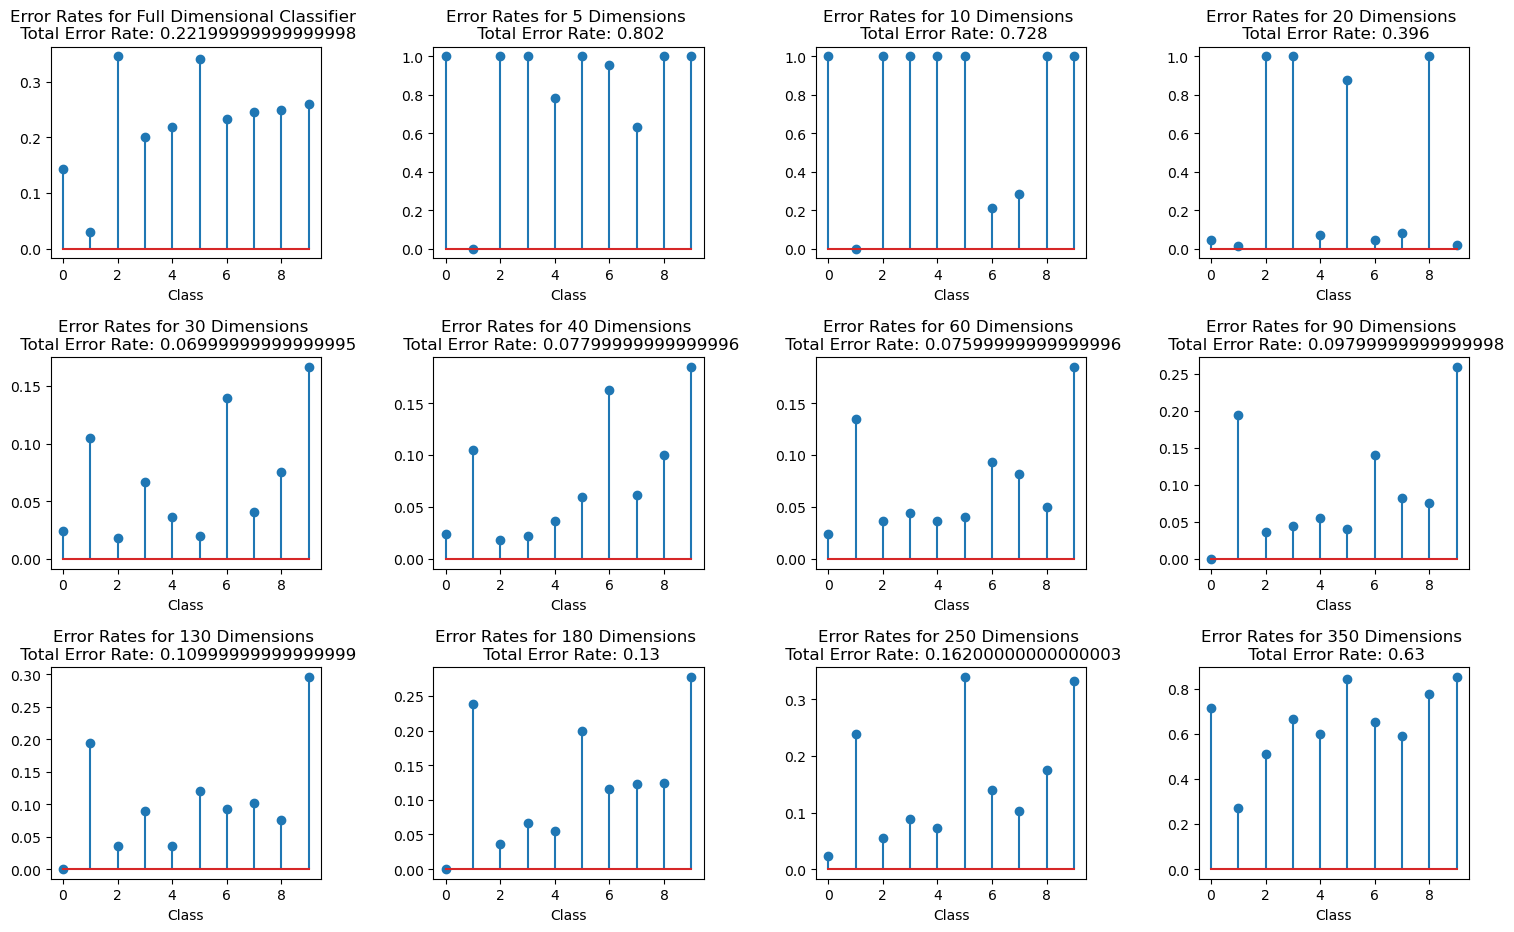

In [15]:
ax, arr = plt.subplots(3,4, figsize=(16, 10))
ax.tight_layout(pad=5.0)
arr[0][0].stem([1-prev_predicted[j]/expected[j] for j in range(10)])
arr[0][0].set_xlabel('Class')
arr[0][0].set_title(f'Error Rates for Full Dimensional Classifier \n Total Error Rate: {1-sum(prev_predicted)/500}')
for i in range(11):
    arr[int((i+1)/4)][(i+1)%4].stem([1-predicted[i][j]/expected[j] for j in range(10)])
    arr[int((i+1)/4)][(i+1)%4].set_xlabel('Class')
    arr[int((i+1)/4)][(i+1)%4].set_title(f'Error Rates for {dimensions[i]} Dimensions \n Total Error Rate: {1-sum(predicted[i])/500}')

## Problem 3
We want to find the index $i$ such that 
$$||y_i - Ax_i||$$
is maximized where $y_i \in \mathbb{R}^{784}$ is the $i$th test image, $Ax_i$ is the orthogonal projection of $y_i$ onto the principal component space $\mathbb{R}^{784 \times 40}$.
Then we want find value for $i$ in the following expression:
$$argmax_i \{||y_i - A(A^TA)^{-1} A^Ty_i\}$$

In [16]:
eigenvalues_5, eigenvectors_5 = np.linalg.eigh(covariance_5)
eigenspace = eigenvectors_5[:,-1:-41:-1]
differences = test_data.T - eigenspace@np.linalg.pinv(eigenspace)@test_data.T
norms = np.linalg.norm(differences, axis=0)
np.argmax(norms)

25

Text(0.5, 1.0, 'Farthest Image with Norm: 6.863051254083657')

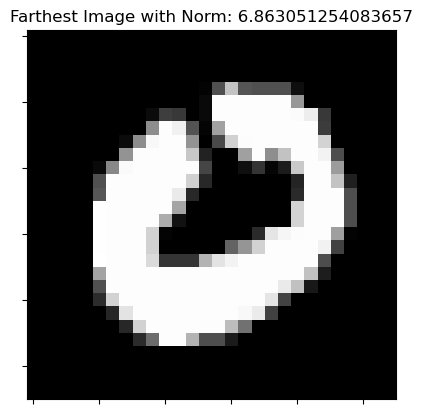

In [17]:
index = 25
ax, arr = plt.subplots(1,1)
arr.imshow(test_data[index,:].reshape((28,28)), cmap='gray')
arr.set_yticklabels([])
arr.set_xticklabels([])
arr.set_title(f'Farthest Image with Norm: {norms[index]}')